# КЕЙС:
У Василия, основателя компании «"@"», дела идут в гору: в этом году он открывает 100 новых скважин по добыче газа. Однако в целях оптимизации расходов и для потенциального повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы потенциально сильнейшим образом влияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста по построению моделей машинного обучения.

Он представляет вам набор данных о добыче газа на своих скважинах.

## Признаки:

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс (кгм);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).
 

## Задача
построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [2]:
# Загрузка датасета
data = pd.read_csv('dataset/unconv.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


## Задание 2.1

In [3]:
def plot_correlation_matrix(data):
    # Построение корреляционной матрицы факторов, с включением в неё целевого признака.
    pearson_corr_matrix = data.corr(method='pearson')

    # Создание маски для скрытия повторяющихся значений
    mask = np.triu(np.ones_like(pearson_corr_matrix, dtype=bool))

    # Создание фигуры
    plt.figure(figsize=(10, 8))

    # Заголовок
    plt.title(f'Корреляция признаков', fontsize=12)

    # Отображение матрицы корреляции
    sns.heatmap(pearson_corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, cbar=True, square=True)

    # Отображение графика
    plt.show()

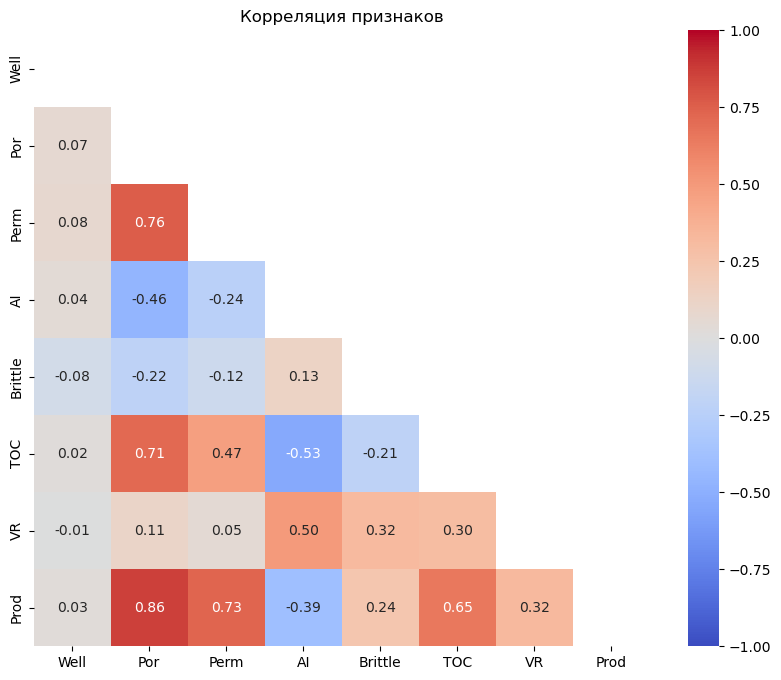

In [4]:
plot_correlation_matrix(data)

In [5]:
pearson_corr_matrix = data.corr(method='pearson')

In [6]:
# Топ-3 скореллированных признака с целевым признаком
print('Топ-3 скореллированных признака с целевым признаком')
display(pearson_corr_matrix
        .drop('Prod', axis=0)['Prod']
        .sort_values(ascending=False)
        .head(3))

Топ-3 скореллированных признака с целевым признаком


Por     0.861910
Perm    0.727426
TOC     0.654445
Name: Prod, dtype: float64

In [7]:
# Вычисление ранга полученной матрицы корреляций
np.linalg.matrix_rank(pearson_corr_matrix)

8

Если ранг матрицы соответствует количеству признаков, это означает, что все признаки являются линейно независимыми.
Формально линейной зависимости между факторами нет, и матрица факторов имеет максимальный ранг. 

In [8]:
# Вычисление определителя матрицы корреляций с точностью до 4 х знаков
np.round(np.linalg.det(pearson_corr_matrix), 4)

0.0007

Обнаружена мультиколлинеарность - матрица корреляции практически вырождена, несмотря на то что имеет максимальный ранг.

## Задание 2.2

In [9]:
#Постройте модель линейной регрессии по методу наименьших квадратов. 
#Для этого используйте матричную формулу NumPy. 
#В качестве ответа укажите полученные оценки коэффициентов модели

In [10]:
# Создание матрицы наблюдений X
X = data.drop('Prod', axis=1).values
ones = np.ones((data.shape[0], 1))
X_ones = np.hstack((ones, X))

# Вектор правильных ответов —  y
y = data['Prod'].values


In [11]:
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X_ones.T@X_ones)@X_ones.T@y
print(w_hat)

[-1.23230803e+03  5.07003631e-02  2.30179140e+02  1.16239006e+02
 -3.65202301e+02  2.49943700e+01 -7.84009294e+01  7.85259815e+02]


In [12]:
# Классическая OLS-регрессия в numpy с возможностью получения решения даже для вырожденных матриц
print(f'Вектор весов: \n{np.linalg.lstsq(X_ones, y, rcond=None)[0]}, \n\n Детерминант: {np.linalg.lstsq(X_ones, y, rcond=None)[2]}')

Вектор весов: 
[-1.23230803e+03  5.07003631e-02  2.30179140e+02  1.16239006e+02
 -3.65202301e+02  2.49943700e+01 -7.84009294e+01  7.85259815e+02], 

 Детерминант: 8


In [13]:
# Собираем оценки в таблицу
w_names = list(map(lambda x: 'w_' + x, (['0'] + list(data.columns)[:-1])))
w = pd.DataFrame(w_hat, index=w_names, columns=['w_hat'])
print('OLS коэффициенты')
display(w)

OLS коэффициенты


,w_hat
w_0,-1232.308030
w_Well,0.050700
w_Por,230.179140
w_Perm,116.239006
w_AI,-365.202301
w_Brittle,24.994370
w_TOC,-78.400929
w_VR,785.259815


In [14]:
print('Отобранные коэффициенты с округлением')
display(np.round(w[0:4])) 
print(f'Признак {w.index[1]} является не информативным')

Отобранные коэффициенты с округлением


,w_hat
w_0,-1232.0
w_Well,0.0
w_Por,230.0
w_Perm,116.0


Признак w_Well является не информативным


## Задание 2.3

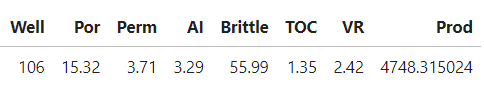

In [15]:
# Новый вектор признаков
arr_200 = np.array([106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42, 4748.315024])
row_200 = pd.DataFrame([arr_200], columns=data.columns, index=[len(data)])
display(row_200)

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
200,106.0,15.32,3.71,3.29,55.99,1.35,2.42,4748.315024


In [16]:
# Построение прогноза выработки газа для скважины 200 с параметрами, указанными ниже.

# Убираем целевой признак из вектора и добавляем единицу в начало этого вектора
new_arr_ones = np.insert(arr_200[:-1], 0, 1)
print(f'Вектор признаков: {new_arr_ones}')

# Сделать прогноз — вычислить скалярное произведение вектора признаков и коэффициентов регрессии
arr_200_prediction = new_arr_ones@w_hat
print(f'Прогнозное значение целевого признака: {arr_200_prediction}')


Вектор признаков: [  1.   106.    15.32   3.71   3.29  55.99   1.35   2.42]
Прогнозное значение целевого признака: 4723.064053707194


In [17]:
# Чему равна абсолютная ошибка построенного вами прогноза для предложенной скважины ?(в миллионах кубических футов в день).
abs_err_200 = np.round(np.abs(arr_200[-1] - arr_200_prediction))
print(f'Абсолютная ошибка прогноза для скважины №200: {abs_err_200} mcf/day')

Абсолютная ошибка прогноза для скважины №200: 25.0 mcf/day


Метрика MAPE:

In [18]:
#Построение прогноза выработки газа для всех скважин из обучающего набора - в нашем случае на полном джатасете. 
y_predictions = X_ones@w_hat

# Вычисление абсолютной ошибки (absolute_error)
absolute_error = np.abs(y - y_predictions)

# Вычисление процентной ошибки (percentage_error)
percentage_error = (absolute_error / y) * 100

# Вычисление средней процентной ошибки (MAPE)
mape = np.mean(percentage_error)

print("MAPE:", np.round(mape, 1), "%")

MAPE: 3.6 %


In [19]:
print('Сравнение знаков коэффициентов регрессии и знаков корреляции факторов')
compare = w[1:].copy().set_index(pd.Index(data.drop('Prod', axis=1).columns))
corr = pearson_corr_matrix.drop('Prod', axis=0)['Prod'].values
compare['corr_with_target'] = corr
compare['result'] = compare['w_hat'] * compare['corr_with_target'] >=0
display(compare)

Сравнение знаков коэффициентов регрессии и знаков корреляции факторов


,w_hat,corr_with_target,result
Well,0.050700,0.026817,True
Por,230.179140,0.861910,True
Perm,116.239006,0.727426,True
AI,-365.202301,-0.390835,True
Brittle,24.994370,0.237155,True
TOC,-78.400929,0.654445,False
VR,785.259815,0.323182,True


## Задание 2.4

Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.


1. Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целью прямая, а модель говорит обратное.

In [20]:
# Фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции
compare[compare['result'] == False]

,w_hat,corr_with_target,result
TOC,-78.400929,0.654445,False


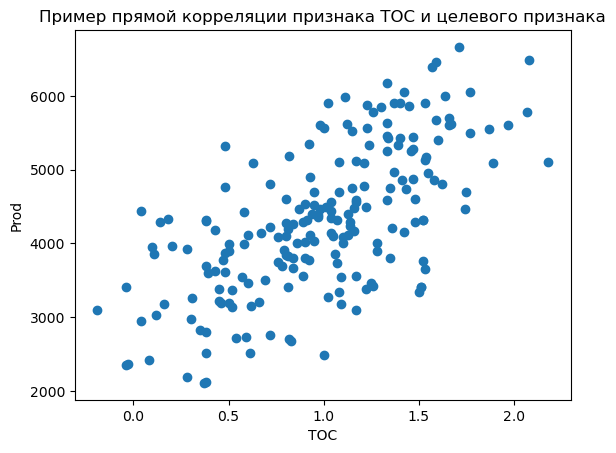

In [21]:

# Построение диаграммы рассеяния
plt.scatter(data['TOC'], data['Prod'])
plt.xlabel('TOC')
plt.ylabel('Prod')
plt.title('Пример прямой корреляции признака TOC и целевого признака')
plt.show()

## Задание 2.5

In [22]:
# Исключение из данных сильно коррелированных между собой факторов.

In [23]:
print('Топ признаков по коллинеарности друг к другу:')
features = data.drop('Prod', axis=1)
features_corr = features.corr()
for col in features_corr.columns:
    features_corr[col][col] = 0
features_corr_top = features_corr.abs().max().sort_values(ascending=False)
display(features_corr_top)


Топ признаков по коллинеарности друг к другу:


Por        0.760546
Perm       0.760546
TOC        0.711831
AI         0.531864
VR         0.499143
Brittle    0.317929
Well       0.079252
dtype: float64

In [24]:
# Высококоррелирующие признаки (> 0.7)
hig_cor_delete_candidate = features_corr_top[features_corr_top > 0.7]
hig_cor_delete_candidate

Por     0.760546
Perm    0.760546
TOC     0.711831
dtype: float64

In [25]:
# Список признаков с низкой корреляцией к таргету (> 0.05)
print('Топ корреляций к таргету:')
high_corr_to_target = pearson_corr_matrix.drop('Prod', axis=0)['Prod'].sort_values(ascending=False).abs()
display(high_corr_to_target)
low_corr_list = list(high_corr_to_target[high_corr_to_target < 0.05].index)
print(f'Признак с низкой корреляцией к таргету: {low_corr_list}')


Топ корреляций к таргету:


Por        0.861910
Perm       0.727426
TOC        0.654445
VR         0.323182
Brittle    0.237155
Well       0.026817
AI         0.390835
Name: Prod, dtype: float64

Признак с низкой корреляцией к таргету: ['Well']


In [26]:
# Финальный список признаков, удовлетиворяет двум условиям
# Корреляция к таргету > 0.05
# Внутренняя корреляция признаков друг с другом < 0.7
data_qood_corr = data.copy().drop(['Perm', 'Well', 'TOC'], axis=1)
data_qood_corr

,Por,AI,Brittle,VR,Prod
0,12.08,2.80,81.40,2.31,4165.196191
1,12.38,3.22,46.17,1.88,3561.146205
2,14.02,4.01,72.80,2.72,4284.348574
3,17.67,2.63,39.81,1.88,5098.680869
4,17.52,3.18,10.94,1.90,3406.132832
...,...,...,...,...,...
195,11.95,2.97,67.18,2.06,3847.571003
196,17.99,3.38,44.32,2.08,5601.227131
197,12.12,3.52,57.07,1.73,3409.575363
198,15.55,2.48,58.25,2.35,5087.592149


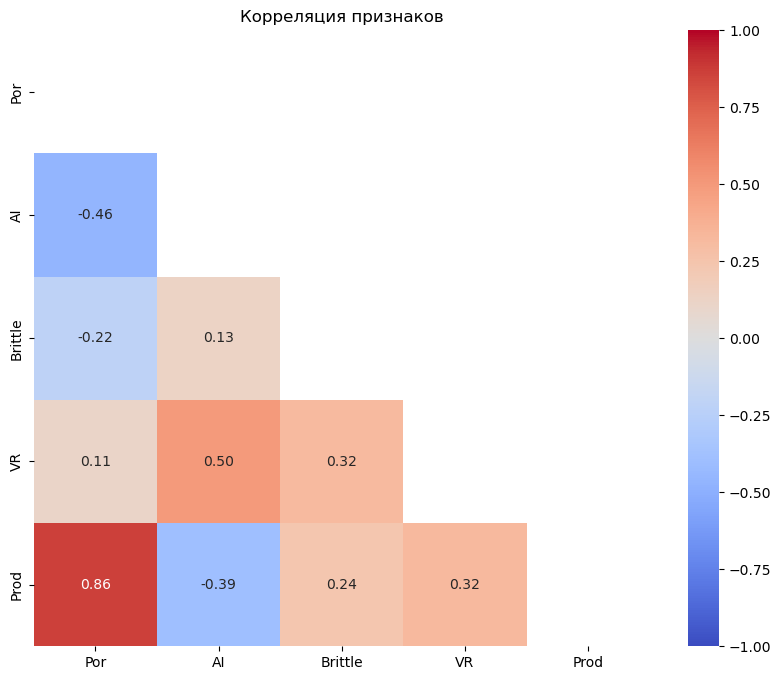

In [27]:
plot_correlation_matrix(data_qood_corr)

In [28]:
#Постройте линейную регрессию на обновлённых после удаления факторов данных по методу наименьших квадратов. 

In [29]:
# Создание матрицы наблюдений X
X = data_qood_corr.drop('Prod', axis=1).values
ones = np.ones((data.shape[0], 1))
X_ones = np.hstack((ones, X))

# Вектор правильных ответов —  y
y = data_qood_corr['Prod'].values


In [30]:
# вычислим OLS-оценку для коэффициентов
w_hat = np.linalg.inv(X_ones.T@X_ones)@X_ones.T@y
print(w_hat)

[-1835.44646069   293.03624565  -200.03091206    27.64098209
   517.40272597]


In [31]:
# Сделайте прогноз для всего обучающего набора данных и рассчитайте метрику MAPE (Mean Absolute Percentage Error).

In [32]:
#Построение прогноза выработки газа для всех скважин из обучающего набора - в нашем случае на полном джатасете. 
y_predictions = X_ones@w_hat

# Вычисление абсолютной ошибки (absolute_error)
absolute_error = np.abs(y - y_predictions)

# Вычисление процентной ошибки (percentage_error)
percentage_error = (absolute_error / y) * 100

# Вычисление средней процентной ошибки (MAPE)
mape = np.mean(percentage_error)

print("MAPE:", np.round(mape, 1), "%")

MAPE: 4.0 %


In [33]:
# Собираем оценки в таблицу
w_names = list(map(lambda x: 'w_' + x, (['0'] + list(data_qood_corr.columns)[:-1])))
w = pd.DataFrame(w_hat, index=w_names, columns=['w_hat'])
print('OLS коэффициенты')
display(round(w))

OLS коэффициенты


,w_hat
w_0,-1835.0
w_Por,293.0
w_AI,-200.0
w_Brittle,28.0
w_VR,517.0


In [34]:
print('Сравнение знаков коэффициентов регрессии и знаков корреляции факторов')
pearson_corr_matrix = data_qood_corr.corr()
compare = w[1:].copy().set_index(pd.Index(data_qood_corr.drop('Prod', axis=1).columns))
corr = pearson_corr_matrix.drop('Prod', axis=0)['Prod'].values
compare['corr_with_target'] = corr
compare['result'] = compare['w_hat'] * compare['corr_with_target'] >=0
display(compare)

Сравнение знаков коэффициентов регрессии и знаков корреляции факторов


,w_hat,corr_with_target,result
Por,293.036246,0.861910,True
AI,-200.030912,-0.390835,True
Brittle,27.640982,0.237155,True
VR,517.402726,0.323182,True


In [35]:
# Детерминант
np.round(np.linalg.det(pearson_corr_matrix), 4)

0.0202

Детерминант стал больше

## Задание 3.1

In [36]:
#Сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей

In [37]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
    # считаем матрицу корреляций (без столбца из единиц)
C = pd.DataFrame(X_poly[:, 1:]).corr()
# считаем ранг корреляционной матрицы
print('Ранг корреляционной матрицы:', np.linalg.matrix_rank(C))
# считаем количество факторов (не включая столбец из единиц)
print('Количество факторов:', X_poly[:, 1:].shape[1])

Ранг корреляционной матрицы: 33
Количество факторов: 33


In [38]:
#Обучите модель линейной регрессии из библиотеки sklearn (LinearRegression) на полученных полиномиальных факторах.

In [39]:
def polynomial_regression_sk(X, y, k):
    poly = PolynomialFeatures(degree=k, include_bias=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    # оцениваем качество модели на кросс-валидации, метрика — MAPE
    cv_results = cross_validate(lr, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
    train_res = cv_results["train_score"].mean()* 100
    test_res = cv_results["test_score"].mean()* 100
    return X_poly, train_res, test_res

In [40]:
#Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.

In [41]:
k = 3
X_poly, train_res, test_res = polynomial_regression_sk(X, y, k)
print('--')
print(f'Порядок полинома: {k}')
print(f'MAPE на тренировочных фолдах: {round(-train_res, 3)} %')
print(f'MAPE на валидационных фолдах: {round(-test_res, 3)} %')
# считаем матрицу корреляций (без столбца из единиц)
C = pd.DataFrame(X_poly[:, 1:]).corr()
# считаем ранг корреляционной матрицы
print('Ранг корреляционной матрицы:', np.linalg.matrix_rank(C))
# считаем количество факторов (не включая столбец из единиц)
print('Количество факторов:', X_poly[:, 1:].shape[1])
    
# 

--
Порядок полинома: 3
MAPE на тренировочных фолдах: 1.773 %
MAPE на валидационных фолдах: 2.681 %
Ранг корреляционной матрицы: 33
Количество факторов: 33


## Задание 3.2

In [42]:
# Обучите модель Lasso из библиотеки sklearn на полученных полиномиальных факторах, 
# предварительно стандартизировав факторы с помощью StandardScaler. 
# Коэффициент регуляризации выставите равным 5.

#Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.

In [43]:
def polynomial_standard_regression_l1_sk(X, y, k, alpha):
    # инициализируем стандартизатор StandardScaler
    scaler = StandardScaler()
    # подгоняем параметры стандартизатора (вычисляем среднее и СКО)
    X_st = scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=k, include_bias=False)
    X_poly_st = poly.fit_transform(X_st)
    # создаём модель линейной регрессии c L1-регуляризацией
    lasso = Lasso(alpha=alpha)
    # оцениваем качество модели на кросс-валидации, метрика — MAPE
    cv_results = cross_validate(
        lasso, 
        X_poly_st, 
        y, 
        scoring='neg_mean_absolute_percentage_error', 
        cv=5, 
        return_train_score=True)
    train_res = cv_results["train_score"].mean()* 100
    test_res = cv_results["test_score"].mean()* 100
    return X_poly_st, train_res, test_res

In [44]:
k = 3 # степень полинома
alpha = 5 # L_1 коэффициент регуляризации
X_poly_st_l1, train_res, test_res = polynomial_standard_regression_l1_sk(X, y, k, alpha)
print('--')
print(f'Порядок полинома: {k}')
print(f'Значение L1 регуляризации: {alpha}')
print(f'MAPE на тренировочных фолдах: {round(-train_res, 2)} %')
print(f'MAPE на валидационных фолдах: {round(-test_res, 2)} %')
# считаем матрицу корреляций (без столбца из единиц)
D = pd.DataFrame(X_poly_st_l1[:, 1:]).corr()
# считаем ранг корреляционной матрицы
print('Ранг корреляционной матрицы:', np.linalg.matrix_rank(D))
# считаем количество факторов (не включая столбец из единиц)
print('Количество полиномиальных факторов:', X_poly_st_l1[:, 1:].shape[1])

--
Порядок полинома: 3
Значение L1 регуляризации: 5
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %
Ранг корреляционной матрицы: 33
Количество полиномиальных факторов: 33


## Задание 3.3

In [45]:
#Обучите модель Ridge из библиотеки sklearn на полученных полиномиальных факторах,
# предварительно стандартизировав факторы с помощью StandardScaler. 
# Коэффициент регуляризации выставите равным 1.

#Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.

In [46]:
def polynomial_standard_regression_l2_sk(X, y, k, alpha):
    # инициализируем стандартизатор StandardScaler
    scaler = StandardScaler()
    # подгоняем параметры стандартизатора (вычисляем среднее и СКО)
    X_st = scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=k, include_bias=False)
    X_poly_st = poly.fit_transform(X_st)
    # создаём модель линейной регрессии c L2-регуляризацией
    ridge = Ridge(alpha=alpha, solver='svd')
    # оцениваем качество модели на кросс-валидации, метрика — MAPE
    cv_results = cross_validate(
        ridge, 
        X_poly_st, 
        y, 
        scoring='neg_mean_absolute_percentage_error', 
        cv=5, 
        return_train_score=True)
    train_res = cv_results["train_score"].mean()* 100
    test_res = cv_results["test_score"].mean()* 100
    return X_poly_st, train_res, test_res

In [47]:
k = 3 # степень полинома
alpha = 1 # L_2 коэффициент регуляризации
X_poly_st_l2, train_res, test_res = polynomial_standard_regression_l2_sk(X, y, k, alpha)
print('--')
print(f'Порядок полинома: {k}')
print(f'Значение L2 регуляризации: {alpha}')
print(f'MAPE на тренировочных фолдах: {round(-train_res, 2)} %')
print(f'MAPE на валидационных фолдах: {round(-test_res, 2)} %')
# считаем матрицу корреляций (без столбца из единиц)
D = pd.DataFrame(X_poly_st_l2[:, 1:]).corr()
# считаем ранг корреляционной матрицы
print('Ранг корреляционной матрицы:', np.linalg.matrix_rank(D))
# считаем количество факторов (не включая столбец из единиц)
print('Количество полиномиальных факторов:', X_poly_st_l2[:, 1:].shape[1])

--
Порядок полинома: 3
Значение L2 регуляризации: 1
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.72 %
Ранг корреляционной матрицы: 33
Количество полиномиальных факторов: 33


## Задание 3.4

Это задание необязательно к выполнению, но за него можно получить дополнительный балл.

Вы обучили модели с L_1 и L_2 регуляризациями, отлично! Однако есть еще более продвинутая модель, которая объединяет в себе обе этих регуляризации. Она реализуется с помощью класса '`sklearn.linear_model.ElasticNet`'. Найдите документацию для данного класса и реализуйте модель с его помощью. Оцените среднее значение метрики MAPE, используя кросс-валидацию на пяти фолдах.
Переберите несколько значений для аргумента l1_ratio, который отвечает за комбинацию двух типов регуляризации (например, с помощью цикла). Выберите значение этого параметра, для которого качество получается наилучшим.

In [48]:
def polynomial_elastic_net(X, y, k, alpha, l1_ratio):
    # инициализируем стандартизатор StandardScaler
    scaler = StandardScaler()
    # подгоняем параметры стандартизатора (вычисляем среднее и СКО)
    X_st = scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=k, include_bias=False)
    X_poly_st = poly.fit_transform(X_st)
    # создаём модель линейной регрессии c L2-регуляризацией
    el = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)
    # оцениваем качество модели на кросс-валидации, метрика — MAPE
    cv_results = cross_validate(
        el, 
        X_poly_st, 
        y, 
        scoring='neg_mean_absolute_percentage_error', 
        cv=5, 
        return_train_score=True)
    train_res = cv_results["train_score"].mean()* 100
    test_res = cv_results["test_score"].mean()* 100
    return X_poly_st, train_res, test_res

In [49]:
best_test_mape = {}  
for l1_ratio in np.arange(0, 1, 0.05): 
    k = 3 # степень полинома
    alpha = 0.2 # параметр смешивания регуляризаций l1 l2
    #l1_ratio = 0.5 # Сила регуляризации
    X_poly_st_el, train_res, test_res = polynomial_elastic_net(X, y, k, alpha, l1_ratio)

    best_test_mape[l1_ratio] = -test_res
min_pair = min(best_test_mape.items(), key=lambda x: x[1])
min_key = min_pair[0]
min_value = min_pair[1]
print('')
print('')
print('')
print("L1_ratio:", round(min_key, 3))
print("MIN MAPE на валидационных фолдах:", round(min_value, 3))
  

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.804e+06, tolerance: 1.612e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.650e+06, tolerance: 1.545e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea




L1_ratio: 0.95
MIN MAPE на валидационных фолдах: 2.746


# Выводы

При построении линейной регрессии для прогнозирования выработки газа на скважине на основе характеристик скважины необходимо учитывать несколько ключевых аспектов, которые могут существенно повлиять на качество и надёжность модели:

* `Вырожденность матриц и детерминант`: 
Для линейной регрессии важно, чтобы матрица признаков была невырожденной, то есть имела ненулевой детерминант. Вырожденность матрицы может возникнуть при наличии линейно зависимых признаков и приводить к проблемам в вычислении обратной матрицы в формуле нормального уравнения. В случае вырожденности матрицы коэффициенты регрессии становятся неопределенными.

* `Стандартизация`: 
Чтобы избежать проблемы различных масштабов признаков и улучшить численную стабильность вычислений, применяется стандартизация данных. Она заключается в преобразовании признаков таким образом, чтобы их среднее было равно 0, а стандартное отклонение — 1. Это особенно полезно при наличии полиномиальных признаков.

* `Полиномиальные признаки`: 
Добавление полиномиальных признаков позволяет модели лучше отражать нелинейности в данных, однако это также увеличивает риск переобучения и может привести к появлению мультиколлинеарности.

* `Коллинеарность и мультиколлинеарность`: 
Коллинеарность (мультиколлинеарность) — это ситуация, когда два или более признака сильно коррелированы, что делает их почти линейно зависимыми. Это может привести к нестабильности оценок коэффициентов и затруднить интерпретацию модели. Чтобы бороться с этим, применяются методы регуляризации и отбора признаков.

`Основные слабые стороны линейной регрессии` включают чувствительность к выбросам, предположение о линейной зависимости между признаками и целевой переменной, а также проблемы, связанные с коллинеарностью.

Мы преодолели этитрудности следующим образом:

`Применение регуляризации`: Для борьбы с коллинеарностью и улучшения обусловленности матрицы  мы использовали методы регуляризации. L1-регуляризация (Lasso) помогает уменьшить веса менее значимых признаков до нуля, тем самым выполняя отбор признаков. L2-регуляризация (Ridge) уменьшает веса признаков, но не зануляет их, что предотвращает вырожденность матрицы. Elastic Net комбинирует оба этих подхода, позволяя одновременно отбирать признаки и снижать влияние коллинеарности.

`Стандартизация данных`: Перед применением регрессии мы стандартизировали данные, чтобы уменьшить влияние различных диапазонов признаков на результаты регрессии, что особенно важно при добавлении полиномиальных признаков.

`Отбор признаков`: Мы также рассмотрели возможность использования методов отбора признаков для удаления ненужных или избыточных признаков, что помогает сократить размерность данных и снизить риск переобучения.

`Кросс-валидация`: Для избежания переобучения и оценки обобщающей способности модели мы использовали кросс-валидацию. Это позволило нам объективно оценить модель на различных подвыборках данных и выбрать оптимальные гиперпараметры для регуляризации.

В итоге, благодаря использованию стандартизации, введению полиномиальных признаков, применению регуляризации, а также кросс-валидации, мы смогли построить устойчивую линейную регрессионную модель,